In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2
import itertools
from scipy.spatial.transform import Rotation as R
from scipy import optimize as optimize

In [3]:
def kitti_get_calibration_cam_to_image(cab_f):
    for line in open(cab_f):
        if 'P2:' in line:
            # Example:
            # P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3, 4))
    return cam_to_img

In [4]:
class KittiLabel:
    """Represent content of one line in the label file
    Description (from devkit): 
    1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
    """
    def __init__(self):
        self.type = None
        self.truncated = None
        self.occluded = None
        self.alpha = None
        self.bbox = None
        self.dimensions = None
        self.location = None
        self.rotation_y = None
        self.score = None
        
    @staticmethod
    def parse_line(line):
        l = line.strip().split(' ')
        if len(l) != 15:
            return None

        label_info = KittiLabel()
        label_info.type = l[0]
        label_info.truncated = float(l[1])
        label_info.occluded = int(l[2])
        label_info.alpha = float(l[3])
        label_info.bbox = np.asarray(l[4:8], dtype=float)
        label_info.dimensions = np.asarray(l[8: 11], dtype=float)
        label_info.location = np.asarray(l[11: 14], dtype=float)
        label_info.rotation_y = float(l[14])
        return label_info
# Unit testing
line = 'Car 0.00 2 -1.77 688.78 183.98 790.47 255.97 1.47 1.59 3.62 2.87 1.74 16.88 -1.61'
label_0 = KittiLabel.parse_line(line)
assert(np.abs(label_0.alpha - (-1.77)) < 1e-5)

In [5]:
def kitti_read_label_file(label_file: str):
    labels = []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            label = KittiLabel.parse_line(line)
            if label is not None:
                labels.append(label)
    return labels

In [6]:
def project_to_image(P, pts):
    n_pts = pts.shape[1]
    #print('pts:', pts)
    #print('ones', np.ones((1, n_pts)))
    X = np.concatenate((pts, np.ones((1, n_pts))), axis=0)
    x = np.dot(P, X)
    x = x[:2, :] / x[2:3, :]
    return x
    

In [7]:
def compute_obj_pose(t_in_body, label: KittiLabel, cam_to_img):
    """Compute location and yaw angle from local angle"""
    
    # Object dimensions
    h, w, l = label.dimensions
    
    # Coordinate of object centers
    # Note that label.location is location of the point at the bottom of the object
    # Need to add half object height to get object center
    tx, ty, tz = t_in_body # label.location
    
    theta_ray = np.arctan2(tx, tz)
    theta_local = label.alpha
    ry = theta_ray + theta_local
    
    obj2body_R = R.from_euler('y', ry).as_dcm()
    obj2body_t = np.array([tx, ty, tz], dtype=float).reshape(-1, 1)
    
    # Box corners
    # x-axis on object (car) points from back to front of car
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

    corners_in_obj = np.asarray([x_corners, y_corners, z_corners], dtype=float)
    corners_in_body = np.dot(obj2body_R, corners_in_obj) + obj2body_t
    
    # Project to image    
    corners_in_img = project_to_image(cam_to_img, corners_in_body)
    
    
    face_idxes = [[0, 1, 5, 4], # front face
             [1, 2, 6, 5], #left face
             [2, 3, 7, 6], # back face
             [3, 0, 4, 7], #right face
               ]
    
    x0, y0, x1, y1 = label.bbox
    p0_pred = np.min(corners_in_img, axis=1)
    p1_pred = np.max(corners_in_img, axis=1)
    
    #print('x0_pred: ', x)
#     err = np.asarray([corners_in_img[0, 4] - x0, corners_in_img[1, 4] - y0,
#                    corners_in_img[0, 2] - x1, corners_in_img[1, 2] - y1])

    err = np.asarray([p0_pred[0] - x0, p0_pred[1] - y0, p1_pred[0] - x1, p1_pred[1] - y1])
    
    #print('corners_in_img:', corners_in_img)
    #print('bbox:', label.bbox)
    #print('err=', err)
    
    return err


In [8]:
def kitti_plot_3d_bbox(img, label:KittiLabel, cam_to_img, is_gt=True):    
    
    colors = {
        'green': (0, 255, 0),
        'pink': (255, 0, 255),
        'blue': (0, 0, 255)
    }
    if is_gt:
        color = colors['green']
    else:
        color = colors['pink']
    
    
    # Object dimensions
    h, w, l = label.dimensions
    
    # Coordinate of object centers
    # Note that label.location is location of the point at the bottom of the object
    # Need to add half object height to get object center
    tx, ty, tz = label.location
    
    theta_ray = np.arctan2(tx, tz)
    theta_local = label.alpha
    theta = theta_ray + theta_local
    
    #ry = label.rotation_y
    ry = theta
    #print('theta = ', theta)
    #print('ry = ', ry)
    
    obj2body_R = R.from_euler('y', ry).as_dcm()
    obj2body_t = np.array([tx, ty, tz], dtype=float).reshape(-1, 1)
    
    # Box corners
    # x-axis on object (car) points from back to front of car
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

    corners_in_obj = np.asarray([x_corners, y_corners, z_corners], dtype=float)
    corners_in_body = np.dot(obj2body_R, corners_in_obj) + obj2body_t
    
    # Project to image    
    corners_in_img = project_to_image(cam_to_img, corners_in_body)
    face_idxes = [[0, 1, 5, 4], # front face
             [1, 2, 6, 5], #left face
             [2, 3, 7, 6], # back face
             [3, 0, 4, 7], #right face
               ]
    
    for idx in face_idxes:
        p1 = corners_in_img[:, idx].astype(int)
        p2 = np.roll(p1, 1, axis=1)
        for i in range(p1.shape[1]):
            cv2.line(img, (p1[0, i], p1[1, i]), (p2[0, i], p2[1, i]), color, 2 )
    return img

In [9]:
def solve_camera_ray_z_eq_z0(P, u, v, z0=1):
    #print('u, v = ', u, v)
    #print('P=', P)
    A = np.zeros((2, 2))
    b = np.zeros(2)
    A[0, 0] = P[0, 0] - u * P[2, 0]
    A[0, 1] = P[0, 1] - u * P[2, 1]
    b[0] = P[0, 2] * z0 + P[0, 3] - u*P[2, 2]*z0 - u*P[2, 3]

    A[1, 0] = P[1, 0] - v * P[2, 0]
    A[1, 1] = P[1, 1] - v * P[2, 1]
    b[1] = P[1, 2] * z0 + P[1, 3] - v*P[2, 2]*z0 - v*P[2, 3]
    x = np.linalg.solve(A, -b)
    return x


In [10]:
def guess_obj_location(label: KittiLabel, cam_to_img):
    # Compute x, y at z=1
    u0, v0, u1, v1 = label.bbox
    P = cam_to_img
    # Set up linear system to solve x, y
    diag = []
    z = [1., 2.]
    for z0 in z:
        p0 = solve_camera_ray_z_eq_z0(P, u0, v0, z0=z0)
        #print('p0: ', p0)
    
        p1 = solve_camera_ray_z_eq_z0(P, u1, v1, z0=z0)
        #print('p1: ', p1)
        d = np.linalg.norm(p1-p0)
        #print('d:', d)
        diag.append(d)
    slope = (diag[1] - diag[0]) / (z[1] - z[0])
    
    # Diagnal of obj 3D box
    d_gt = np.linalg.norm(label.dimensions)
    #print('d_gt=', d_gt)
    z_gt = (d_gt - diag[0]) / slope + z[0]
    p_gt = solve_camera_ray_z_eq_z0(P, (u0+u1)/2, (v0+v1)/2, z0=z_gt)
    
    loc = *p_gt, z_gt
    #print('loc:', loc)
    return loc

[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
Ground location: [3.28 1.71 7.32]
Computed location: [3.24126056 1.68686258 7.24768205]
Ground location: [-2.21  1.53 22.12]
Computed location: [-2.20700168  1.50551356 22.05094658]
Ground location: [ 4.69  1.76 32.17]
Computed location: [ 4.66112028  1.74178893 32.04974531]
Ground location: [-0.84  1.62 39.13]
Computed location: [-0.84586008  1.59965216 38.83073549]


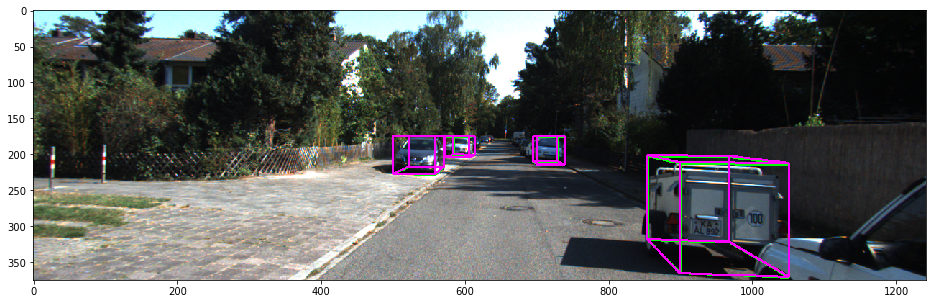

In [11]:
def main():
    img_file = './kitti_2d/training/image_2/007095.png'
    label_file = './kitti_2d/training/label_2/007095.txt'
    calib_file = './kitti_2d/training/calib/007095.txt'
    image = cv2.imread(img_file, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    labels = kitti_read_label_file(label_file)
    labels = [l for l in labels if l.type != 'DontCare']
    
    cam_to_img = kitti_get_calibration_cam_to_image(calib_file)
    print(cam_to_img)
    
    for label_info in labels:
        if label_info.truncated > 0:
            continue
        
        # Draw ground truth bounding box
        image = kitti_plot_3d_bbox(image, label_info, cam_to_img, True)
        
        # Compute 3D location from local angle and camera libration
        x_init = guess_obj_location(label_info, cam_to_img)
        #x_init = np.asarray([1.0, 1.0, 1.0], dtype=float)
        x_init = np.asarray(x_init)
        res = optimize.leastsq(lambda x: compute_obj_pose(x, label_info, cam_to_img=cam_to_img), x_init)
        
        print('Ground location:', label_info.location)
        print('Computed location:', res[0])
        label_info.location = res[0]
        
        # Overlay 3D box using computed location
        image = kitti_plot_3d_bbox(image, label_info, cam_to_img, False)
    return image

img = main()
plt.figure(figsize=(16, 16))
plt.imshow(img)
plt.savefig('img_with_box3d.png')